In [1]:
!pip install pubchempy transformers datasets rdkit pandas tqdm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 49.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.8 MB/s eta 0:00:00
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13819 sha256=4234a03ecc5621fbb694e21b8bc8954ff513aa4c352cc653eed81552b74f15e5
  Stored in directory: /root/.cache/pip/wheels/8b/e3/6c/3385b2db08b0985a87f5b117f98d0cb61a3ae3ca3bcbbd8307
Successfully built pubchempy
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platfo

In [6]:
"""
Enhanced SMILES Generator using Chemistry-Aware Language Models
"""
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
torch.backends.cudnn.benchmark = True

import pubchempy as pcp
import time
from urllib.error import HTTPError, URLError
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
)

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors
import warnings
warnings.filterwarnings('ignore')

# Disable WANDB
os.environ["WANDB_DISABLED"] = "true"

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class SMILESDataset(Dataset):
    """Custom dataset for SMILES strings"""
    def __init__(self, smiles_list, tokenizer, max_length=64):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.inputs = []

        for smiles in tqdm(smiles_list, desc="Tokenizing SMILES"):
            # Add special tokens for better learning
            text = f"<smiles>{smiles}</smiles>"
            encodings = tokenizer(
                text,
                truncation=True,
                max_length=self.max_length,
                padding="max_length",
                return_tensors="pt"
            )
            self.inputs.append({
                'input_ids': encodings['input_ids'][0],
                'attention_mask': encodings['attention_mask'][0]
            })

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx]

def download_chembl_smiles(max_compounds=50000, batch_size=2500, delay=1.0):
    """Download SMILES strings from PubChem in batches to avoid timeouts"""
    valid_smiles = []
    for start in range(1, max_compounds + 1, batch_size):
        end = min(start + batch_size, max_compounds + 1)
        try:
            compounds = pcp.get_compounds(list(range(start, end)), namespace='cid')
            for compound in compounds:
                if compound.isomeric_smiles:
                    mol = Chem.MolFromSmiles(compound.isomeric_smiles)
                    if mol:
                        valid_smiles.append(compound.isomeric_smiles)
        except (HTTPError, URLError, TimeoutError) as e:
            print(f"[Warning] Skipping compounds {start}-{end-1} due to error: {e}")
            continue
        time.sleep(delay)  # be kind to the API

        print(f"Fetched and validated: {len(valid_smiles)} molecules so far...")

    return valid_smiles


def preprocess_dataset():
    """Preprocess SMILES strings and prepare datasets"""
    # Get SMILES data
    smiles_list = download_chembl_smiles(max_compounds=50000)
    print(f"Total valid SMILES: {len(smiles_list)}")

    # Split into train/validation sets
    np.random.shuffle(smiles_list)
    split_idx = int(len(smiles_list) * 0.9)
    train_smiles = smiles_list[:split_idx]
    val_smiles = smiles_list[split_idx:]

    return train_smiles, val_smiles


Using device: cuda


In [7]:
def create_tokenizer_and_model(model_name="gpt2-medium"):
    """Initialize tokenizer and model"""
    # Use a chemistry-aware model if available
    # For demo, we'll fine-tune GPT-2-medium which has better capacity than base GPT-2
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Add special tokens for SMILES
    special_tokens = {
        'pad_token': '[PAD]',
        'bos_token': '<smiles>',
        'eos_token': '</smiles>',
        'additional_special_tokens': ['[C]', '[O]', '[N]', '[S]', '[Cl]', '[F]', '[Br]', '[I]', '[P]',
                                      '[=]', '[(]', '[)]', '[N+]', '[O-]', '[#]']
    }

    # Add special tokens to tokenizer
    tokenizer.add_special_tokens(special_tokens)

    # Initialize model
    model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
    model.resize_token_embeddings(len(tokenizer))

    return tokenizer, model


In [8]:
def train_smiles_generator(model, tokenizer, train_smiles, val_smiles, output_dir="./smiles-generator"):
    """Train the SMILES generator model"""
    # Create datasets
    train_dataset = SMILESDataset(train_smiles, tokenizer)
    val_dataset = SMILESDataset(val_smiles, tokenizer)

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")

    # Configure training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        num_train_epochs=2,  # Adjust based on dataset size
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        save_steps=50000,
        prediction_loss_only=False,
        logging_dir=f"{output_dir}/logs",
        logging_steps=50000,
        save_total_limit=1,
        fp16=True if torch.cuda.is_available() else False,
        gradient_accumulation_steps=1,
        learning_rate=1e-4,  # Lower learning rate for fine-tuning
    )

    # Data collator for language modeling
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False  # We're doing causal language modeling, not masked
    )

    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
    )

    # Train the model
    print("Starting training...")
    trainer.train()

    # Save model and tokenizer
    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"Model saved to {output_dir}")

    return model, tokenizer

def generate_novel_smiles(model, tokenizer, num_sequences=50, max_length=64, temperature=0.7, top_p=0.9):
    """Generate novel SMILES strings"""
    # Set model to evaluation mode
    model.eval()
    model.to(device)

    # Generation parameters
    generation_config = {
        "do_sample": True,
        "top_p": top_p,
        "temperature": temperature,
        "top_k": 50,
        "max_length": max_length,
        "num_return_sequences": num_sequences,
        "pad_token_id": tokenizer.pad_token_id,
        "bos_token_id": tokenizer.bos_token_id,
        "eos_token_id": tokenizer.eos_token_id,
    }

    # Generate sequences
    input_ids = tokenizer("<smiles>", return_tensors="pt").input_ids.to(device)

    # Generate with guidance
    outputs = model.generate(input_ids, **generation_config)

    # Decode generated SMILES
    generated_smiles = []
    for output in outputs:
        decoded = tokenizer.decode(output, skip_special_tokens=True)
        # Extract SMILES string between tags if present
        if "<smiles>" in decoded and "</smiles>" in decoded:
            smiles = decoded.split("<smiles>")[1].split("</smiles>")[0].strip()
        else:
            smiles = decoded.strip()
        generated_smiles.append(smiles)

    return generated_smiles

def validate_smiles(smiles_list):
    """Validate generated SMILES and calculate properties"""
    valid_mols = []
    valid_smiles = []
    properties = []

    for smiles in smiles_list:
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                valid_mols.append(mol)
                valid_smiles.append(smiles)

                # Calculate basic molecular properties
                properties.append({
                    'SMILES': smiles,
                    'MolWeight': round(Descriptors.MolWt(mol), 2),
                    'LogP': round(Descriptors.MolLogP(mol), 2),
                    'NumHDonors': Descriptors.NumHDonors(mol),
                    'NumHAcceptors': Descriptors.NumHAcceptors(mol),
                    'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),
                    'TPSA': round(Descriptors.TPSA(mol), 2)
                })
        except:
            continue

    print(f"Generated {len(smiles_list)} SMILES, {len(valid_smiles)} valid ({len(valid_smiles)/len(smiles_list)*100:.1f}%)")

    return valid_mols, valid_smiles, properties

def visualize_molecules(mols, n_per_row=5, max_mols=50):
    """Visualize generated molecules"""
    if len(mols) > max_mols:
        mols = mols[:max_mols]

    img = Draw.MolsToGridImage(
        mols,
        molsPerRow=n_per_row,
        subImgSize=(250, 250),
        legends=[f"Mol {i+1}" for i in range(len(mols))]
    )
    return img




In [9]:
train_smiles, val_smiles = preprocess_dataset()

[23:27:17] WARNING: not removing hydrogen atom without neighbors
[23:27:17] WARNING: not removing hydrogen atom without neighbors
[23:27:18] Explicit valence for atom # 22 Cl, 3, is greater than permitted


Fetched and validated: 2499 molecules so far...
Fetched and validated: 4999 molecules so far...
Fetched and validated: 7499 molecules so far...
Fetched and validated: 9999 molecules so far...
Fetched and validated: 12499 molecules so far...
Fetched and validated: 14999 molecules so far...
Fetched and validated: 17499 molecules so far...
Fetched and validated: 19999 molecules so far...
Fetched and validated: 22499 molecules so far...


[23:30:31] Explicit valence for atom # 1 Cl, 7, is greater than permitted
[23:30:31] Explicit valence for atom # 1 Br, 3, is greater than permitted
[23:30:31] Explicit valence for atom # 1 Br, 5, is greater than permitted
[23:30:31] Explicit valence for atom # 1 Cl, 3, is greater than permitted
[23:30:31] WARNING: not removing hydrogen atom without neighbors
[23:30:31] Explicit valence for atom # 1 Cl, 4, is greater than permitted


Fetched and validated: 24994 molecules so far...
Fetched and validated: 24994 molecules so far...


[23:31:02] WARNING: not removing hydrogen atom without neighbors
[23:31:02] WARNING: not removing hydrogen atom without neighbors
[23:31:02] WARNING: not removing hydrogen atom without neighbors
[23:31:02] WARNING: not removing hydrogen atom without neighbors
[23:31:02] WARNING: not removing hydrogen atom without neighbors


Fetched and validated: 27494 molecules so far...


[23:31:24] WARNING: not removing hydrogen atom without neighbors
[23:31:24] WARNING: not removing hydrogen atom without neighbors


Fetched and validated: 29994 molecules so far...
Fetched and validated: 29994 molecules so far...
Fetched and validated: 32494 molecules so far...
Fetched and validated: 34994 molecules so far...
Fetched and validated: 37494 molecules so far...
Fetched and validated: 39994 molecules so far...
Fetched and validated: 42494 molecules so far...
Fetched and validated: 44994 molecules so far...
Total valid SMILES: 44994


In [10]:
# Initialize tokenizer and model
tokenizer, model = create_tokenizer_and_model()

# Train model
model, tokenizer = train_smiles_generator(model, tokenizer, train_smiles, val_smiles)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
Tokenizing SMILES: 100%|██████████| 4500/4500 [00:01<00:00, 4102.54it/s]
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Train dataset size: 40494
Validation dataset size: 4500
Starting training...


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss


Model saved to ./smiles-generator


In [14]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [15]:
# Generate novel molecules
generated_smiles = generate_novel_smiles(model, tokenizer, num_sequences=200)

In [16]:
generated_smiles

['COC1=CC2=C(C=C1)NC=C2CCN',
 'COC1=CC(=CC(=C1OC)OC)C(=O)C2=CC=C(C=C2)OCC[NH+](CCCl)CCCl.[Cl-]',
 'CC(C)CCCC(C)O',
 'CCN(CC)CCOC(=O)C(C1=CC=CC=C1)(C2=CC=CC=C2)OC',
 'C1=CC=C(C=C1)N(CCO)CCO',
 'C1=CC(=CC=C1C=C(C#N)C(=O)NCC(=O)O)(=O)',
 'C(=O)(C(=O)).[Ca+2]',
 'CCN(CC)CCNC(=O)C1=CC(=C(C(=C1)Cl)NC(=O)C2=CC=C(C=C2)Cl)Cl',
 'CC1=CC=CC=C1N=NC2=CC=C(C=C2)C(=O)O',
 'C1=CC=C(C=C1)C(=O)C2=CC=CC=C2C(=O)O',
 'COC1=CC=CC=C1NC(=O)CC2=CC=CC=C2',
 'C1=CC=C(C=C1)C(=O)N',
 'C1=CC=C2C(=C1)C(=C3C=CC=CC3=N2)NC4=CC=C(C=C4)NC5=C6C=CC=CC6=NC7=CC=CC=C7C8',
 'CCN(CC)C1=CC(=C(C=C1)C(C)C)OCC',
 'C1=CC=C(C=C1)C(=O)C2=CC=CC=C2',
 'C1=CC=C(C=C1)C(=O)C=CC2=CC=CC=C2',
 'CCCCCCCCCCCCCCCC(=O)OCC',
 'C1=CC=C(C=C1)C2=CC(=C(C=C2)Cl)Cl',
 'C1=CC=C(C=C1)C(=O)C=CC2=CC=C(O2)(=O)',
 'CC(=O)OC1=CC=C(C=C1)C(=O)C2=CC=C(C=C2)OC(=O)C',
 'CC(=O)NC1=CC=C(C=C1)C(=O)O',
 'C1=CC=C(C=C1)C2=CC=C(C=C2)N=NC3=CC=C(C=C3)O',
 'CCCC(=O)O[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CCC4=CC(=O)CC[C@]34C)C',
 'CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)OC(=O

In [17]:
mols, valid_smiles, properties = validate_smiles(generated_smiles)

Generated 200 SMILES, 185 valid (92.5%)


[00:48:23] Explicit valence for atom # 2 C, 5, is greater than permitted
[00:48:23] SMILES Parse Error: unclosed ring for input: 'C1=CC=C2C(=C1)C(=C3C=CC=CC3=N2)NC4=CC=C(C=C4)NC5=C6C=CC=CC6=NC7=CC=CC=C7C8'
[00:48:23] Explicit valence for atom # 13 C, 5, is greater than permitted
[00:48:23] SMILES Parse Error: extra open parentheses while parsing: C1=CC(=CC=C1C2=CC=C(C=C2)N=NC3=C(C=C4C=C(C=CC4=C3O)S(=O)(=O))N=NC5=C6
[00:48:23] SMILES Parse Error: check for mistakes around position 6:
[00:48:23] C1=CC(=CC=C1C2=CC=C(C=C2)N=NC3=C(C=C4C=C(
[00:48:23] ~~~~~^
[00:48:23] SMILES Parse Error: Failed parsing SMILES 'C1=CC(=CC=C1C2=CC=C(C=C2)N=NC3=C(C=C4C=C(C=CC4=C3O)S(=O)(=O))N=NC5=C6' for input: 'C1=CC(=CC=C1C2=CC=C(C=C2)N=NC3=C(C=C4C=C(C=CC4=C3O)S(=O)(=O))N=NC5=C6'
[00:48:23] SMILES Parse Error: syntax error while parsing: C1=CC=C2C(=C1)C(=C3C=CC=CC3=N2)[NH2+]CCCCCCCCCCCCCOC4=CC=CC=C4OCCCCCCCCCCCCCCCCCOC5=CC=CC=
[00:48:23] SMILES Parse Error: check for mistakes around position 90:
[00:48:23] CC

In [18]:
# Display results
print(f"\nExample valid SMILES generated:")
for i, smiles in enumerate(valid_smiles[:]):
        print(f"{i+1}. {smiles}")



Example valid SMILES generated:
1. COC1=CC2=C(C=C1)NC=C2CCN
2. COC1=CC(=CC(=C1OC)OC)C(=O)C2=CC=C(C=C2)OCC[NH+](CCCl)CCCl.[Cl-]
3. CC(C)CCCC(C)O
4. CCN(CC)CCOC(=O)C(C1=CC=CC=C1)(C2=CC=CC=C2)OC
5. C1=CC=C(C=C1)N(CCO)CCO
6. C(=O)(C(=O)).[Ca+2]
7. CCN(CC)CCNC(=O)C1=CC(=C(C(=C1)Cl)NC(=O)C2=CC=C(C=C2)Cl)Cl
8. CC1=CC=CC=C1N=NC2=CC=C(C=C2)C(=O)O
9. C1=CC=C(C=C1)C(=O)C2=CC=CC=C2C(=O)O
10. COC1=CC=CC=C1NC(=O)CC2=CC=CC=C2
11. C1=CC=C(C=C1)C(=O)N
12. CCN(CC)C1=CC(=C(C=C1)C(C)C)OCC
13. C1=CC=C(C=C1)C(=O)C2=CC=CC=C2
14. C1=CC=C(C=C1)C(=O)C=CC2=CC=CC=C2
15. CCCCCCCCCCCCCCCC(=O)OCC
16. C1=CC=C(C=C1)C2=CC(=C(C=C2)Cl)Cl
17. CC(=O)OC1=CC=C(C=C1)C(=O)C2=CC=C(C=C2)OC(=O)C
18. CC(=O)NC1=CC=C(C=C1)C(=O)O
19. C1=CC=C(C=C1)C2=CC=C(C=C2)N=NC3=CC=C(C=C3)O
20. CCCC(=O)O[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CCC4=CC(=O)CC[C@]34C)C
21. CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)OC(=O)C5CCCC5)C)C
22. CC1=CC2=C(C=C1C)N=C(S2)N
23. CC1(CCCC2=C1C=C(C=C2)OC(=O)NC)C
24. C(C(C(C(C(=O)O)O)O)O)C(=O)O
25. CC(=O)NC1=CC=C(C=C1)C=C

In [19]:
for i, properties in enumerate(properties[:]):
        print(f"{i+1}. {properties}")


1. {'SMILES': 'COC1=CC2=C(C=C1)NC=C2CCN', 'MolWeight': 190.25, 'LogP': 1.68, 'NumHDonors': 2, 'NumHAcceptors': 2, 'NumRotatableBonds': 3, 'TPSA': 51.04}
2. {'SMILES': 'COC1=CC(=CC(=C1OC)OC)C(=O)C2=CC=C(C=C2)OCC[NH+](CCCl)CCCl.[Cl-]', 'MolWeight': 492.83, 'LogP': -0.31, 'NumHDonors': 1, 'NumHAcceptors': 5, 'NumRotatableBonds': 13, 'TPSA': 58.43}
3. {'SMILES': 'CC(C)CCCC(C)O', 'MolWeight': 130.23, 'LogP': 2.19, 'NumHDonors': 1, 'NumHAcceptors': 1, 'NumRotatableBonds': 4, 'TPSA': 20.23}
4. {'SMILES': 'CCN(CC)CCOC(=O)C(C1=CC=CC=C1)(C2=CC=CC=C2)OC', 'MolWeight': 341.45, 'LogP': 3.46, 'NumHDonors': 0, 'NumHAcceptors': 4, 'NumRotatableBonds': 9, 'TPSA': 38.77}
5. {'SMILES': 'C1=CC=C(C=C1)N(CCO)CCO', 'MolWeight': 181.23, 'LogP': 0.48, 'NumHDonors': 2, 'NumHAcceptors': 3, 'NumRotatableBonds': 5, 'TPSA': 43.7}
6. {'SMILES': 'C(=O)(C(=O)).[Ca+2]', 'MolWeight': 98.11, 'LogP': -1.0, 'NumHDonors': 0, 'NumHAcceptors': 2, 'NumRotatableBonds': 1, 'TPSA': 34.14}
7. {'SMILES': 'CCN(CC)CCNC(=O)C1=CC(=C(C(

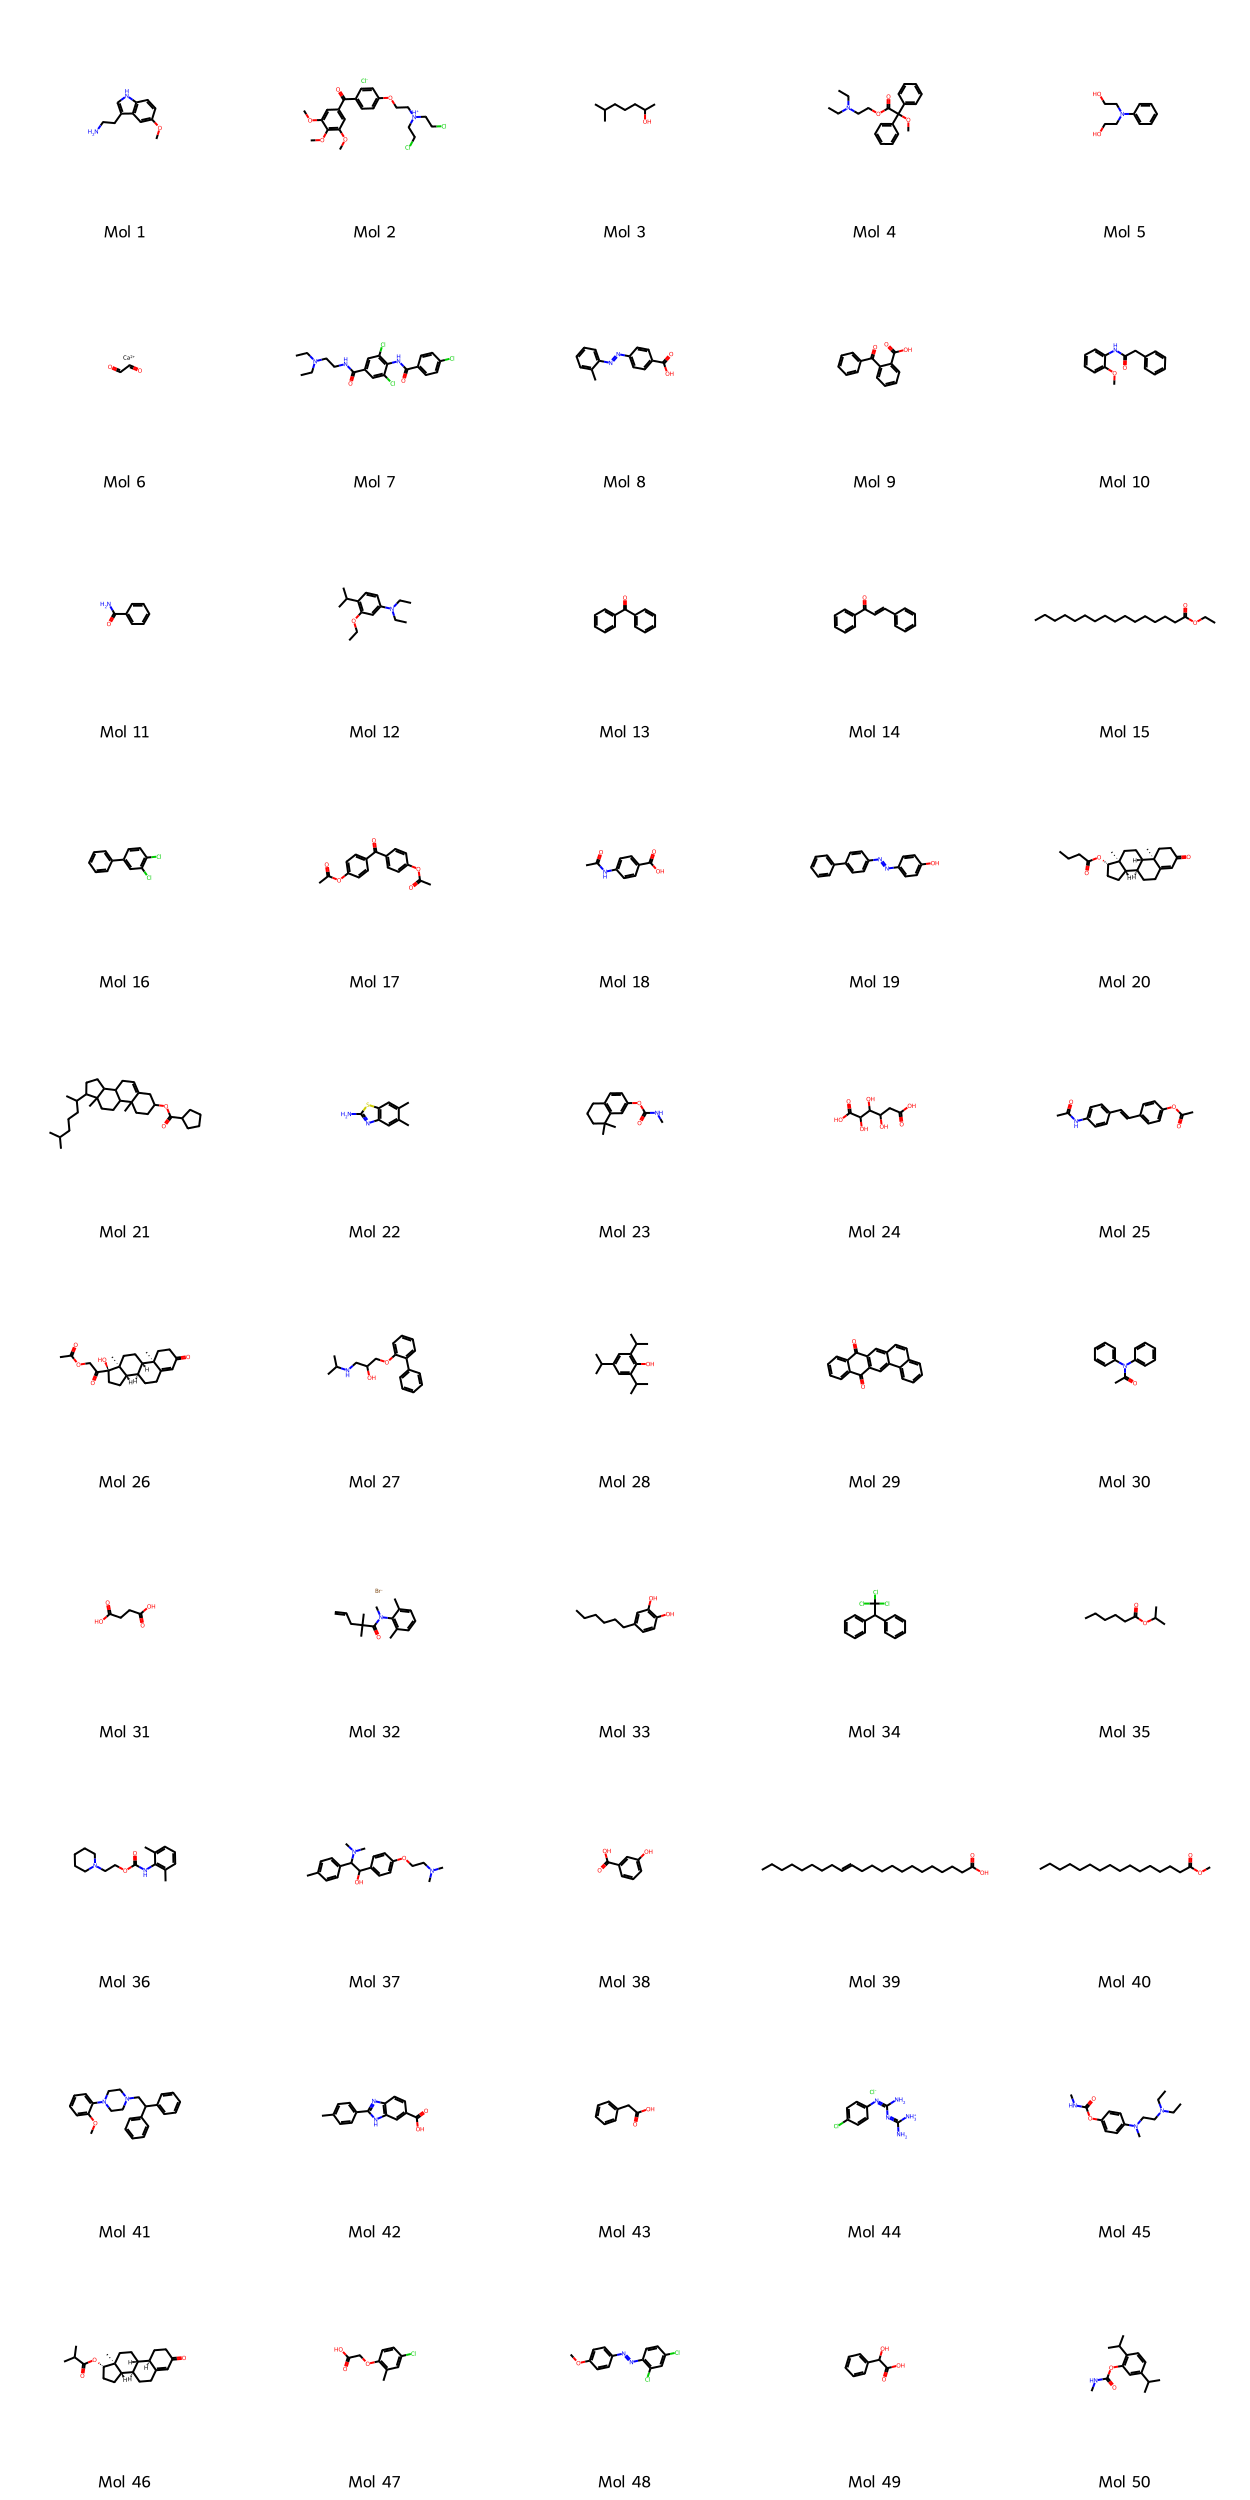

In [20]:
from IPython.display import display
display(visualize_molecules(mols[:]))


In [21]:
gc.collect()
torch.cuda.empty_cache()

In [22]:
generated_smiles = generate_novel_smiles(model, tokenizer, num_sequences=200)

In [23]:
generated_smiles

['C1=CC(=CC=C1C2=CC=C(C=C2)N=NC3=C(C=C4C=CC(=CC4=C3O)S(=O)(=O))N)O.[Na+]',
 'COC1=CC=CC=C1C(=O)O',
 'CCN(CC)CCOC1=C(C=C(C=C1)C(=O)OCC)C',
 'CCCCCCCCCCCCCCCCCCCC(=O)O',
 'CC1=CC(=C(C=C1)C)NC(=O)C',
 'C1=CC=C(C=C1)CC2=NC3=CC=CC=C3N2',
 'CC1=CC(=C(C=C1)C)NC(=O)OC2CCN(CC2)C(=O)CC3=CC=CC=C3',
 'C1=CC(=CC=C1C(C(=O)O)N)Cl',
 'C1=CC(=C(C=C1C(=O)O)Cl)Cl',
 'C1=CC=C(C=C1)CC(C(=O)O)N',
 'CC(C)C1(C(=O)NC(=O)NC1=O)C(C)C',
 'CC1=CC(=C(C=C1)C)C',
 'C1=CC=C2C(=C1)C=CC(=C2N=NC3=CC=C(C=C3)S(=O)(=O))O.[Na+]',
 'CC1=CC2=C(C=C1)C3=C(C2=O)C=C(C=C3)N',
 'CC(=O)NC1=CC=CC=C1O',
 'CC1(C2=CC=CC=C2N(C1=O)CC[NH+]3CCCCC3)C4=CC=CC=C4.[Cl-]',
 'C1=CC=C(C=C1)C(=O)C(Cl)Cl',
 'CC1=CC=C(C=C1)C(=O)C2=CC=C(C=C2)OC',
 'CC1=C(C(=O)N(N1C)C2=CC=CC=C2)N',
 'C1CC2=C(C=CC(=C2)Cl)N=C1',
 'C(=C(Cl)Cl)(F)F',
 'C1=CC(=CC=C1N=NC2=C(C=C(C=C2)(=O))(=O))Cl',
 'CC1=C(C=C(C=C1)NC2=NC(=NC(=N2)Cl)NC3=CC=C(C=C3)Cl)Cl',
 'CC1=CC(=CC(=C1)O)C(=O)N[C@@H]2CCCC[C@H]2[NH+]3CCCCC3.[Cl-]',
 'CCCC(C)C1=CC(=C(C=C1)O)O',
 'C1CC(OC1)C2=CC=CC=C2',
 'CCN(CC

In [24]:
mols, valid_smiles, properties = validate_smiles(generated_smiles)

Generated 200 SMILES, 187 valid (93.5%)


[00:48:29] Explicit valence for atom # 9 C, 5, is greater than permitted
[00:48:29] Explicit valence for atom # 2 C, 5, is greater than permitted
[00:48:29] SMILES Parse Error: unclosed ring for input: 'CC1=CC=C(C=C1)C(C2=CC=C(C=C2)O)C(=O)NC3CC4CCN(CC4)C'
[00:48:29] Explicit valence for atom # 2 C, 6, is greater than permitted
[00:48:29] SMILES Parse Error: syntax error while parsing: C1=CC=C2C(=C1)C=CC(=C2N=NC3=C(C4=CC=CC=C4C=C3S(=O)(=O))S(=O)(=O))O.[Na
[00:48:29] SMILES Parse Error: check for mistakes around position 70:
[00:48:29] )(=O))S(=O)(=O))O.[Na
[00:48:29] ~~~~~~~~~~~~~~~~~~~~^
[00:48:29] SMILES Parse Error: Failed parsing SMILES 'C1=CC=C2C(=C1)C=CC(=C2N=NC3=C(C4=CC=CC=C4C=C3S(=O)(=O))S(=O)(=O))O.[Na' for input: 'C1=CC=C2C(=C1)C=CC(=C2N=NC3=C(C4=CC=CC=C4C=C3S(=O)(=O))S(=O)(=O))O.[Na'
[00:48:29] SMILES Parse Error: extra open parentheses while parsing: CCCCCCCCCCCCCCCC(=O)OCC(COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)O
[00:48:29] SMILES Parse Error: check for mist

In [25]:
# Display results
print(f"\nExample valid SMILES generated:")
for i, smiles in enumerate(valid_smiles[:]):
        print(f"{i+1}. {smiles}")



Example valid SMILES generated:
1. C1=CC(=CC=C1C2=CC=C(C=C2)N=NC3=C(C=C4C=CC(=CC4=C3O)S(=O)(=O))N)O.[Na+]
2. COC1=CC=CC=C1C(=O)O
3. CCN(CC)CCOC1=C(C=C(C=C1)C(=O)OCC)C
4. CCCCCCCCCCCCCCCCCCCC(=O)O
5. CC1=CC(=C(C=C1)C)NC(=O)C
6. C1=CC=C(C=C1)CC2=NC3=CC=CC=C3N2
7. CC1=CC(=C(C=C1)C)NC(=O)OC2CCN(CC2)C(=O)CC3=CC=CC=C3
8. C1=CC(=CC=C1C(C(=O)O)N)Cl
9. C1=CC(=C(C=C1C(=O)O)Cl)Cl
10. C1=CC=C(C=C1)CC(C(=O)O)N
11. CC(C)C1(C(=O)NC(=O)NC1=O)C(C)C
12. CC1=CC(=C(C=C1)C)C
13. C1=CC=C2C(=C1)C=CC(=C2N=NC3=CC=C(C=C3)S(=O)(=O))O.[Na+]
14. CC1=CC2=C(C=C1)C3=C(C2=O)C=C(C=C3)N
15. CC(=O)NC1=CC=CC=C1O
16. CC1(C2=CC=CC=C2N(C1=O)CC[NH+]3CCCCC3)C4=CC=CC=C4.[Cl-]
17. C1=CC=C(C=C1)C(=O)C(Cl)Cl
18. CC1=CC=C(C=C1)C(=O)C2=CC=C(C=C2)OC
19. CC1=C(C(=O)N(N1C)C2=CC=CC=C2)N
20. C1CC2=C(C=CC(=C2)Cl)N=C1
21. C(=C(Cl)Cl)(F)F
22. CC1=C(C=C(C=C1)NC2=NC(=NC(=N2)Cl)NC3=CC=C(C=C3)Cl)Cl
23. CC1=CC(=CC(=C1)O)C(=O)N[C@@H]2CCCC[C@H]2[NH+]3CCCCC3.[Cl-]
24. CCCC(C)C1=CC(=C(C=C1)O)O
25. C1CC(OC1)C2=CC=CC=C2
26. CCN(CC)CCNC(=O)C1=CC=CC2=C

In [26]:
for i, properties in enumerate(properties[:]):
        print(f"{i+1}. {properties}")


1. {'SMILES': 'C1=CC(=CC=C1C2=CC=C(C=C2)N=NC3=C(C=C4C=CC(=CC4=C3O)S(=O)(=O))N)O.[Na+]', 'MolWeight': 442.45, 'LogP': 1.89, 'NumHDonors': 4, 'NumHAcceptors': 7, 'NumRotatableBonds': 4, 'TPSA': 125.34}
2. {'SMILES': 'COC1=CC=CC=C1C(=O)O', 'MolWeight': 152.15, 'LogP': 1.39, 'NumHDonors': 1, 'NumHAcceptors': 2, 'NumRotatableBonds': 2, 'TPSA': 46.53}
3. {'SMILES': 'CCN(CC)CCOC1=C(C=C(C=C1)C(=O)OCC)C', 'MolWeight': 279.38, 'LogP': 2.89, 'NumHDonors': 0, 'NumHAcceptors': 4, 'NumRotatableBonds': 8, 'TPSA': 38.77}
4. {'SMILES': 'CCCCCCCCCCCCCCCCCCCC(=O)O', 'MolWeight': 312.54, 'LogP': 7.11, 'NumHDonors': 1, 'NumHAcceptors': 1, 'NumRotatableBonds': 18, 'TPSA': 37.3}
5. {'SMILES': 'CC1=CC(=C(C=C1)C)NC(=O)C', 'MolWeight': 163.22, 'LogP': 2.26, 'NumHDonors': 1, 'NumHAcceptors': 1, 'NumRotatableBonds': 1, 'TPSA': 29.1}
6. {'SMILES': 'C1=CC=C(C=C1)CC2=NC3=CC=CC=C3N2', 'MolWeight': 208.26, 'LogP': 3.15, 'NumHDonors': 1, 'NumHAcceptors': 1, 'NumRotatableBonds': 2, 'TPSA': 28.68}
7. {'SMILES': 'CC1=CC(=

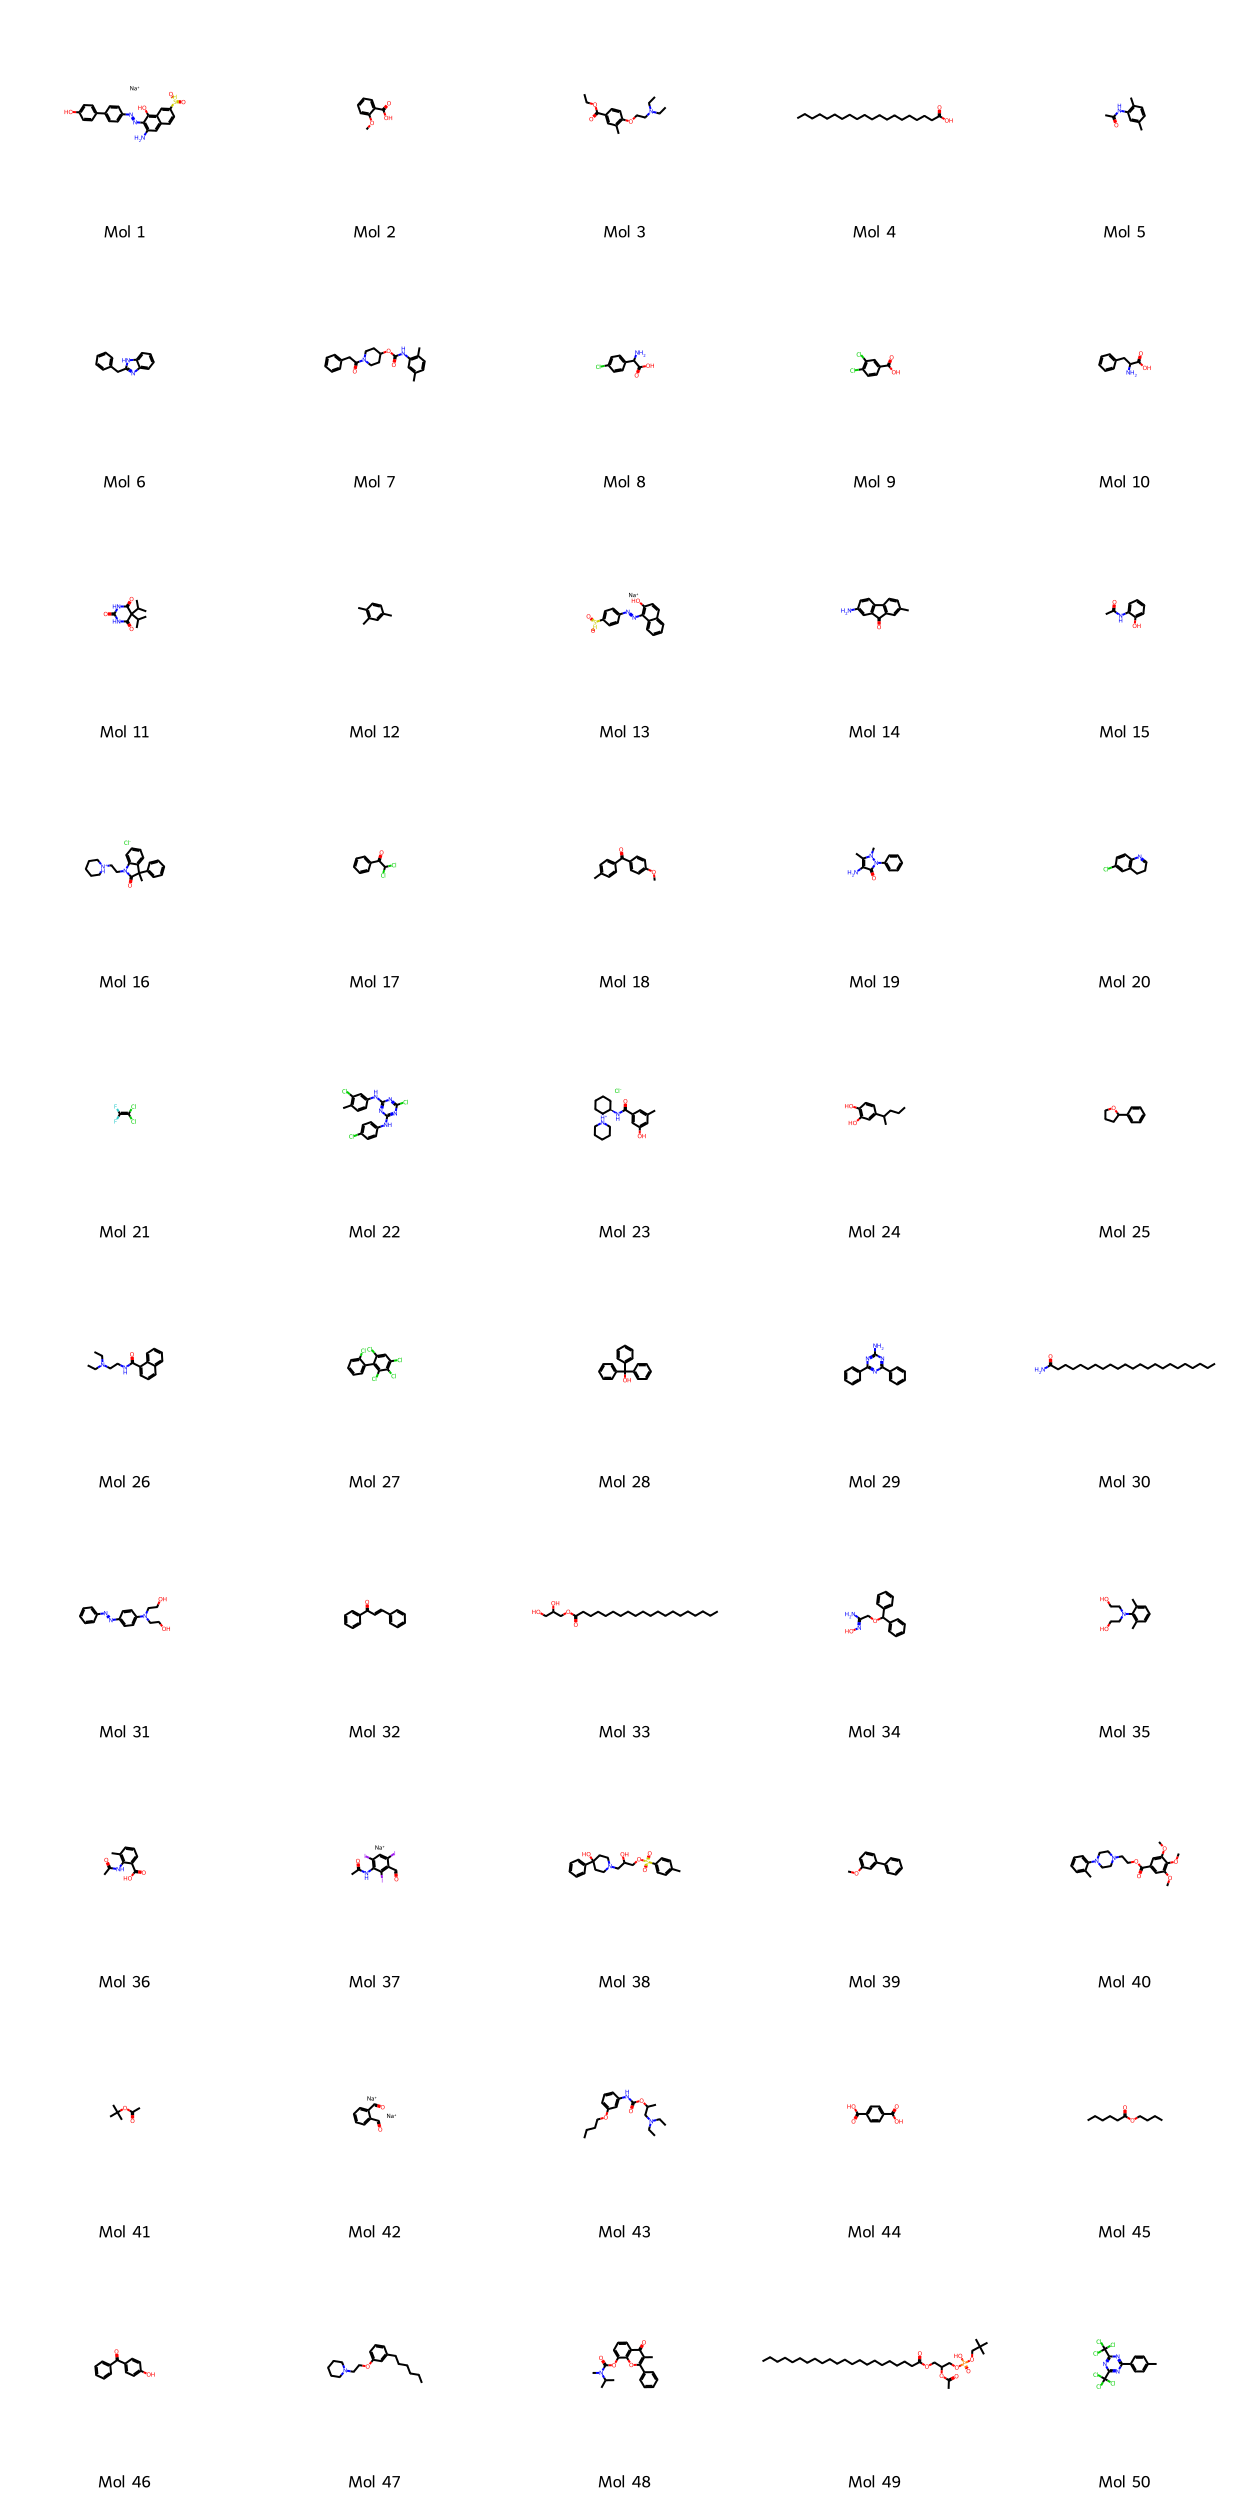

In [27]:
from IPython.display import display
display(visualize_molecules(mols[:]))
